In [60]:
library(ggplot2)
library(ggExtra)
library(brms)
library(reshape2)
library(coda)
library(tidybayes)
library(ggstance)
library(viridis)
library(latex2exp)
library(ggthemes)
library(data.table)
library(bayesplot)
# library(fitdistrplus)
library(bda)

Warning message:
"package 'bda' was built under R version 3.5.2"

In [28]:
data_path = "C:/Users/Arkady/Google Drive/data/beyond_the_reach"

In [103]:
get_data <- function(data_path, file_name){
    data <- read.table(file.path(file_path, file_name), header = TRUE, sep = "\t")
    data[, 'subj_id'] <- factor(data[, 'subj_id'])  
    data[, 'task'] <- factor(data[, 'task'])  
    data[, 'order'] <- factor(data[, 'order']) 
    data$k_original <- data$k
    data$k_reversed <- 1-data$k
    return(data)
}

# Preregistered analysis

Contrary to what was assumed at the time of preregistration, k-values aren't approximated well by the normal distribution. Still, we check Bayes factors according to the originally specified design (`gaussian` family parameter in brms)

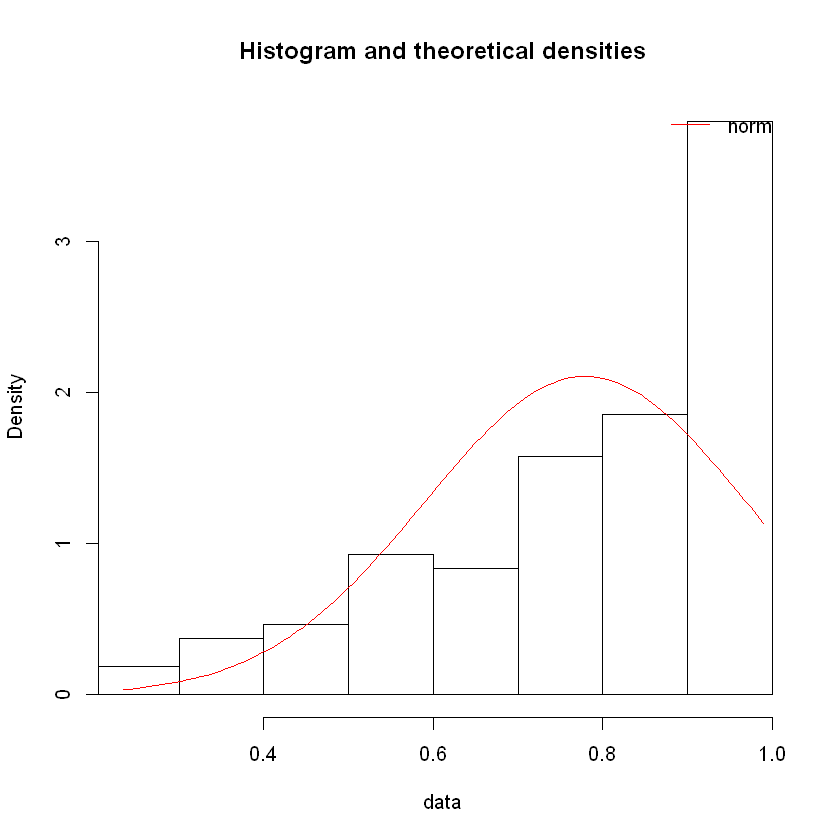

In [80]:
fit_w  <- fitdist(data$k_original, "norm")
denscomp(fit_w)

In [93]:
get_bf_k <- function(data, var, family){
    # sd(IV) in this case is 0.5, as IV is task (equal number of 0's and 1's)
    priors_task <- c(set_prior(sprintf('normal(%f, %f)', mean(data[, var]), sd(data[, var])), class='Intercept'),
                    set_prior(sprintf('cauchy(0.0, %f)', 0.707*sd(data[, var])/0.5), class='b'))
    
    priors_bias <- c(set_prior(sprintf('normal(%f, %f)', mean(data$k), sd(data$k)), class='Intercept'),                    
                    set_prior(sprintf('cauchy(0.0, %f)', 0.707*sd(data$k)/sd(data$SS_bias)), class='b'),
                    set_prior(sprintf('cauchy(0.0, %f)', 0.707*sd(data$k)/0.5), class='b', coef='taskwalking'))
    
    formula_null <- as.formula(paste(var, "~ (1 | subj_id)"))
    formula_task <- as.formula(paste(var, "~ (1 | subj_id) + task"))
    formula_order <- as.formula(paste(var, "~ (1 | subj_id) + order"))
    
    m_null <- brm(formula_null, data=data, family=family, save_all_pars=TRUE, prior=priors_task[1,],
                  refresh=0, control = list(adapt_delta = 0.9, max_treedepth=15))
    m_task <- brm(formula_task, data=data, family=family, save_all_pars=TRUE, prior=priors_task, 
                  refresh=0, control = list(adapt_delta = 0.9, max_treedepth=15))    
    m_order <- brm(formula_order, data=data, family=family, save_all_pars=TRUE, prior=priors_task, 
                  refresh=0, control = list(adapt_delta = 0.9, max_treedepth=15))
#     m_inter <- brm(k ~ (1 | subj_id) + task*order, data=data, family=gaussian(), save_all_pars=TRUE, prior=priors_task, 
#                   refresh=0, control = list(adapt_delta = 0.9, max_treedepth=15))
#     m_bias <- brm(k ~ (1 | subj_id) + task:SS_bias, data=data, family=gaussian(), save_all_pars=TRUE, 
#                   prior=priors_bias, refresh=0, control = list(adapt_delta = 0.9, max_treedepth=15))
    
    bf_task <- bayes_factor(x1=m_task, x2=m_null)$bf
    bf_order <- bayes_factor(x1=m_order, x2=m_null)$bf
#     bf_inter <- bayes_factor(x1=m_inter, x2=m_null)$bf
#     bf_bias <- bayes_factor(x1=m_bias, x2=m_null)$bf
    
    names(bf_task) <- 'bf_task'
    names(bf_order) <- 'bf_order'
#     names(bf_inter) <- 'bf_inter'
#     names(bf_bias) <- 'bf_bias'
        
    result = list(bf=t(c(
                         bf_task, 
                         bf_order
#                         , bf_inter 
#                          bf_bias
                         )), 
                  m_null=m_null, 
                  m_task=m_task, 
                  m_order=m_order
#                   , m_inter=m_inter
#                   m_bias=m_bias
                 )
    
    return(result)
}

show_result <- function(result) {
    print("Bayes factors: ")
    print(result$bf)
    hpd_task<-HPDinterval(as.mcmc(result$m_task, combine_chains = TRUE))
    hpd_order<-HPDinterval(as.mcmc(result$m_order, combine_chains = TRUE))
    print("Credible interval for the task effect (walking relative to mouse): ")
    print(hpd_task['b_taskwalking',])
    print("Credible interval for the order effect (2nd task relative to 1st): ")
    print(hpd_order['b_order2',])
#     mcmc_areas_ridges(as.matrix(as.mcmc(result$m_task, combine_chains = TRUE)), regex_pars = "b_task", prob=0.95)
}

In [111]:
data <- get_data(data_path, "k_values_54.csv")
print(nrow(data))

[1] 108


In [94]:
result <- get_bf_k(data, 'k_original', gaussian())

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.329 seconds (Warm-up)
               0.14 seconds (Sampling)
               0.469 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.39 seconds (Warm-up)
               0.141 seconds (Sampling)
               0.531 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.359 seconds (Warm-up)
               0.141 seconds (Sampling)
               0.5 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.343 seconds (War

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.484 seconds (Warm-up)
               0.219 seconds (Sampling)
               0.703 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.438 seconds (Warm-up)
               0.218 seconds (Sampling)
               0.656 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.453 seconds (Warm-up)
               0.188 seconds (Sampling)
               0.641 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.468 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.439 seconds (Warm-up)
               0.188 seconds (Sampling)
               0.627 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.422 seconds (Warm-up)
               0.203 seconds (Sampling)
               0.625 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.422 seconds (Warm-up)
               0.187 seconds (Sampling)
               0.609 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.453 seconds 

In [96]:
show_result(result)

[1] "Bayes factors: "
       bf_task  bf_order
[1,] 0.0744733 0.2870342
[1] "Credible interval for the task effect (walking relative to mouse): "
      lower       upper 
-0.02683126  0.05117544 
[1] "Credible interval for the order effect (2nd task relative to 1st): "
       lower        upper 
-0.004769027  0.069056773 


# Exploratory analysis

After reaching BF>10 in favor of null model over the model with the main effect of task, we terminated data collection, even though BF of the model with the order effect has not yet reached the designated boundary of 10. The  as it became evident that there is no difference in discounting behavior between tasks.  Just in case, we checked that this holds if we change the `family` parameter of the brms regression to `weibull`, as Weibull distribution more closely matches the distribution of k-values (we ran the model on zero-peaked quantity `1-k`)

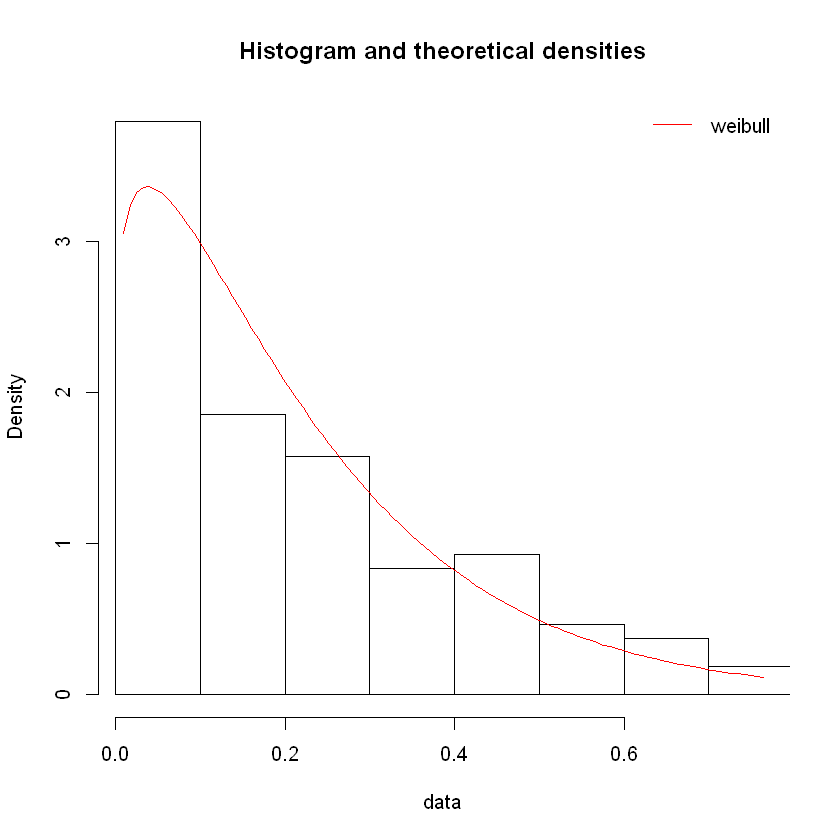

In [113]:
fit_w  <- fitdist(data$k_reversed, "weibull")
denscomp(fit_w)

In [105]:
result <- get_bf_k(data, 'k_reversed', weibull())

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.194 seconds (Warm-up)
               4.835 seconds (Sampling)
               10.029 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.854 seconds (Warm-up)
               6.388 seconds (Sampling)
               12.242 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.755 seconds (Warm-up)
               5.127 seconds (Sampling)
               10.882 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.043 secon

Warning message:
"There were 2 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.911 seconds (Warm-up)
               4.313 seconds (Sampling)
               11.224 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.628 seconds (Warm-up)
               5.848 seconds (Sampling)
               13.476 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.874 seconds (Warm-up)
               6.494 seconds (Sampling)
               13.368 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.626 secon

Warning message:
"There were 1 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.294 seconds (Warm-up)
               5.604 seconds (Sampling)
               12.898 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.743 seconds (Warm-up)
               5.417 seconds (Sampling)
               12.16 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.003 seconds (Warm-up)
               7.439 seconds (Sampling)
               14.442 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.643 second

Warning message:
"There were 1 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7


In [107]:
show_result(result)

[1] "Bayes factors: "
       bf_task  bf_order
[1,] 0.3973595 0.7951576
[1] "Credible interval for the task effect (walking relative to mouse): "
     lower      upper 
-0.1135569  0.2367126 
[1] "Credible interval for the order effect (2nd task relative to 1st): "
      lower       upper 
-0.05444213  0.29836770 


The Bayes factors in favor of the null model decreased and became less conclusive. We however think that using a modified definition of k-value can help to further clarify whether the task or order afffected k. 

Specifically, as many subjects are close to the head part of the k-value distribution (0.9 to 1.0), we might want to emphasize small differences in discounting curves for these subjects. We can do this by changing the definition of k-value in line with Killeen's additive utility model of delay discounting. Specifically, we use log-scaled delays when calculating k-values (which are recorded to \_log.csv files during preprocessing). 

In [115]:
data <- get_data(data_path, "k_values_54_log.csv")
print(nrow(data))

[1] 108


These k-values are more normally distributed

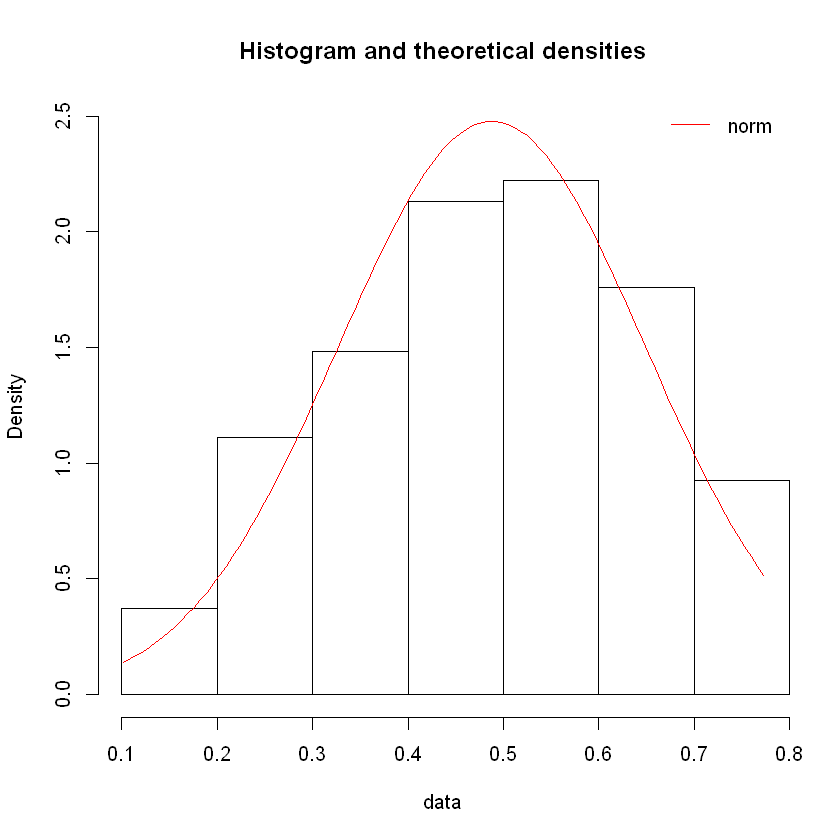

In [116]:
fit_w  <- fitdist(data$k_original, "norm")
denscomp(fit_w)

In [117]:
result <- get_bf_k(data, 'k_original', gaussian())

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 1.103 seconds (Warm-up)
               0.344 seconds (Sampling)
               1.447 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.845 seconds (Warm-up)
               0.443 seconds (Sampling)
               1.288 seconds (Total)


Gradient evaluation took 0.004 seconds
1000 transitions using 10 leapfrog steps per transition would take 40 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.821 seconds (Warm-up)
               0.385 seconds (Sampling)
               1.206 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.841 sec

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 1.23 seconds (Warm-up)
               0.467 seconds (Sampling)
               1.697 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 1.083 seconds (Warm-up)
               0.468 seconds (Sampling)
               1.551 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 1.279 seconds (Warm-up)
               0.565 seconds (Sampling)
               1.844 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 1.48 seconds (W

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 1.02 seconds (Warm-up)
               0.481 seconds (Sampling)
               1.501 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 1.417 seconds (Warm-up)
               0.499 seconds (Sampling)
               1.916 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 1.731 seconds (Warm-up)
               0.529 seconds (Sampling)
               2.26 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 1.485 seconds (W

In [119]:
show_result(result)

[1] "Bayes factors: "
        bf_task bf_order
[1,] 0.07454048 266.5397
[1] "Credible interval for the task effect (walking relative to mouse): "
      lower       upper 
-0.04428725  0.02074099 
[1] "Credible interval for the order effect (2nd task relative to 1st): "
      lower       upper 
-0.09071445 -0.03377009 


TODO

Will the results change if we 

* do not discard subjects based on invalid trajectories (k_values_60/60_log - two conditions)
* discard subjects with extreme discounting in either task (k_values_55/49/_log - 4 conditions)
* account for some individuals' bias towards the LL choice